In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, ElasticNetCV, LassoCV, RidgeCV, Lasso, SGDRegressor
from data_cleaner import eliza_cleaning, eliza_fillna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, Normalizer, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [29]:
raw_datas = pd.read_csv('https://raw.githubusercontent.com/JulienAlardot/challenge-collecting-data/main/Data/database.csv')
datas = eliza_cleaning(raw_datas)
datas = eliza_fillna(datas)

In [30]:
median = pd.read_csv('median.csv')
post = pd.read_csv('post_codes.csv', sep=';')
median['Gemeente'] = median['Gemeente'].str.lower()
post['Commune Principale'] = post['Commune principale'].str.lower()
median_with_post = median.merge(post[['Code postal', 'Commune Principale']], how='left', left_on='Gemeente', right_on='Commune Principale')
median_with_post = median_with_post.groupby('Gemeente').median()
median_with_post['Mediaanprijs 2020'].fillna(median_with_post['Mediaanprijs 2019'], inplace=True)
median_with_post['Mediaanprijs 2020'].fillna(median_with_post['Mediaanprijs 2018'], inplace=True)
median_with_post.sort_values(by='Code postal', inplace=True)
median_with_post.fillna(method='bfill', inplace=True)
median_with_post.reset_index(inplace=True)
median = median.merge(median_with_post[['Gemeente', 'Mediaanprijs 2020']], on='Gemeente')
median_with_post = median.merge(post[['Code postal', 'Commune Principale']], how='left', left_on='Gemeente', right_on='Commune Principale')
median_prices = median_with_post[['Code postal', 'Mediaanprijs 2020_y']]
median_prices.columns = ['postal_code', 'median_price']
median_prices = median_prices.groupby('postal_code').mean()
median_prices.reset_index(inplace=True)
median_prices['postal_code'] = median_prices['postal_code'].astype('int64')
datas = datas.merge(median_prices, how='left', left_on='locality', right_on='postal_code')
datas.drop('postal_code', inplace=True, axis=1)
datas.sort_values(by='locality', ascending=False, inplace=True)
datas['median_price'].fillna(method='ffill', inplace=True)
datas['median_price'] = datas['median_price']
datas.sort_index(inplace=True)
#datas.drop(columns=['locality', 'terrace', 'garden','province', 'region' ], inplace=True)
col = datas.columns
col = [col[0]]+[col[-1]]+list(col[1:-1])
datas = datas[col]
datas.head()

,price,median_price,locality,number_of_rooms,area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,surface_of_the_land,number_of_facades,swimming_pool,state_of_the_building,province,region,type_of_property
0,319799.0,426.25,2970,1,NaN,0,0,0,1,11,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
1,291999.0,426.25,2970,1,NaN,0,0,0,1,6,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
2,764999.0,426.25,2970,2,153.0,0,0,0,1,62,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
3,660264.0,426.25,2970,3,NaN,0,0,0,1,160,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
4,294999.0,247.00,3200,2,80.0,0,0,0,0,0,0,0,0.0,<NA>,0,unkown,Vlaams-Brabant,Vlaams,apartment


In [31]:
y = datas.pop('price')
X = datas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


fillna = ColumnTransformer(
        [('imp_col1', SimpleImputer(strategy='mean'), ['area', 'terrace_area', 'garden_area', 
                                                      'surface_of_the_land']),
         ('imp_col2', SimpleImputer(strategy='median'), ['number_of_rooms', 'number_of_facades']),
        ],remainder='passthrough')

enc = ColumnTransformer(
        [
         ('enc', OneHotEncoder(sparse = False, drop ='first'), [-4, -3,-2,-1]),
         #('enc2', OneHotEncoder(sparse = False, handle_unknown='ignore'), [-7])
        ], remainder='passthrough')

In [32]:
from sklearn.preprocessing import MinMaxScaler
pipe = make_pipeline(fillna, enc, MinMaxScaler(), StandardScaler())
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

In [33]:
my_XGB_model = XGBRegressor()
my_XGB_model.fit(X_train, np.log(y_train), verbose=False)

# make predictions
XGB_predictions = my_XGB_model.predict(X_val)
XGB_predictions = np.exp(XGB_predictions)
# Print MAE for initial XGB model
XGB_mae = mean_absolute_error(XGB_predictions, y_val)
print("Validation MAE for XGBoost Model : " + str(XGB_mae))
      
# Additional Passes
my_XGB_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_XGB_model.fit(X_train, np.log(y_train), early_stopping_rounds=5, 
             eval_set=[(X_val, np.log(y_val))], verbose=False)
XGB_predictions = my_XGB_model.predict(X_val)
XGB_predictions = np.exp(XGB_predictions)
XGB_mult_mae = mean_absolute_error(XGB_predictions, y_val)
print("Validation MAE for multi-pass XGBoost Model : " + str(XGB_mult_mae))



preds_test = my_XGB_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error( y_test, np.exp(preds_test)))
print("RMSE: %f" % (rmse))
score = my_XGB_model.score(X_test,  np.log(y_test))
print(score)
exp_reg_score = evs( np.log(y_test), preds_test)        
print(score)

manual =[rmse_test, exp_reg_score, score] 
               
preds_train = my_XGB_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error( y_train, np.exp(preds_train)))
print("RMSE_Train: %f" % (rmse_train))
print(my_XGB_model.score(X_train,  np.log(y_train)))
print(evs( np.log(y_train),  preds_train))

Validation MAE for XGBoost Model : 89704.40912179653
Validation MAE for multi-pass XGBoost Model : 87843.99396181185
RMSE: 208970.683560
0.7562265349226537
0.7562265349226537
RMSE_Train: 173407.453170
0.803343427060097
0.8033434270689428


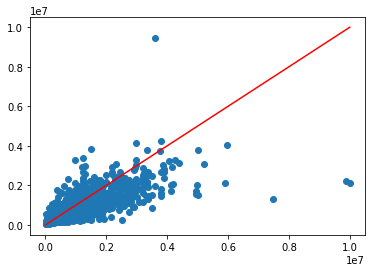

In [34]:
plt.scatter(y_test, np.exp(preds_test))
plt.plot([0,1e7], [0,1e7], color='red')
plt.show()

# Hyperparameters tuning

In [273]:
raw_datas = pd.read_csv('https://raw.githubusercontent.com/JulienAlardot/challenge-collecting-data/main/Data/database.csv')
datas = eliza_cleaning(raw_datas)
datas = eliza_fillna(datas)

In [274]:
median = pd.read_csv('median.csv')
post = pd.read_csv('post_codes.csv', sep=';')
median['Gemeente'] = median['Gemeente'].str.lower()
post['Commune Principale'] = post['Commune principale'].str.lower()
median_with_post = median.merge(post[['Code postal', 'Commune Principale']], how='left', left_on='Gemeente', right_on='Commune Principale')
median_with_post = median_with_post.groupby('Gemeente').median()
median_with_post['Mediaanprijs 2020'].fillna(median_with_post['Mediaanprijs 2019'], inplace=True)
median_with_post['Mediaanprijs 2020'].fillna(median_with_post['Mediaanprijs 2018'], inplace=True)
median_with_post.sort_values(by='Code postal', inplace=True)
median_with_post.fillna(method='bfill', inplace=True)
median_with_post.reset_index(inplace=True)
median = median.merge(median_with_post[['Gemeente', 'Mediaanprijs 2020']], on='Gemeente')
median_with_post = median.merge(post[['Code postal', 'Commune Principale']], how='left', left_on='Gemeente', right_on='Commune Principale')
median_prices = median_with_post[['Code postal', 'Mediaanprijs 2020_y']]
median_prices.columns = ['postal_code', 'median_price']
median_prices = median_prices.groupby('postal_code').mean()
median_prices.reset_index(inplace=True)
median_prices['postal_code'] = median_prices['postal_code'].astype('int64')
datas = datas.merge(median_prices, how='left', left_on='locality', right_on='postal_code')
datas.drop('postal_code', inplace=True, axis=1)
datas.sort_values(by='locality', ascending=False, inplace=True)
datas['median_price'].fillna(method='ffill', inplace=True)
datas['median_price'] = datas['median_price']
datas.sort_index(inplace=True)
#datas.drop(columns=['locality', 'terrace', 'garden','province', 'region' ], inplace=True)
col = datas.columns
col = [col[0]]+[col[-1]]+list(col[1:-1])
datas = datas[col]
datas.head()

,price,median_price,locality,number_of_rooms,area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,surface_of_the_land,number_of_facades,swimming_pool,state_of_the_building,province,region,type_of_property
0,319799.0,426.25,2970,1,NaN,0,0,0,1,11,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
1,291999.0,426.25,2970,1,NaN,0,0,0,1,6,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
2,764999.0,426.25,2970,2,153.0,0,0,0,1,62,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
3,660264.0,426.25,2970,3,NaN,0,0,0,1,160,0,0,0.0,<NA>,0,unkown,Antwerp,Vlaams,apartment
4,294999.0,247.00,3200,2,80.0,0,0,0,0,0,0,0,0.0,<NA>,0,unkown,Vlaams-Brabant,Vlaams,apartment


In [275]:
y = datas.pop('price')
X = datas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


fillna = ColumnTransformer(
        [('imp_col1', SimpleImputer(strategy='mean'), ['area', 'terrace_area', 'garden_area', 
                                                      'surface_of_the_land']),
         ('imp_col2', SimpleImputer(strategy='median'), ['number_of_rooms', 'number_of_facades']),
        ],remainder='passthrough')

enc = ColumnTransformer(
        [
         ('enc', OneHotEncoder(sparse = False, drop ='first'), [-4, -3,-2,-1]),
         #('enc2', OneHotEncoder(sparse = False, handle_unknown='ignore'), [-7])
        ], remainder='passthrough')

In [276]:
from sklearn.preprocessing import MinMaxScaler
pipe = make_pipeline(fillna, enc, MinMaxScaler(), StandardScaler())
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(X_test)

In [279]:
params = {
    # Parameters that we are going to tune.
    #'n_estimators' : 1000,
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}
params['eval_metric'] = "mae"

In [253]:
dtrain = xgb.DMatrix(X_train, label=np.log(y_train))
dtest = xgb.DMatrix(X_test, label=np.log(y_test))

In [230]:
num_boost_round = 9999
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-rmse:8.47859
[1]	Test-rmse:5.94246
[2]	Test-rmse:4.16890
[3]	Test-rmse:2.93059
[4]	Test-rmse:2.06859
[5]	Test-rmse:1.46954
[6]	Test-rmse:1.05908
[7]	Test-rmse:0.78229
[8]	Test-rmse:0.60108
[9]	Test-rmse:0.48750
[10]	Test-rmse:0.42084
[11]	Test-rmse:0.38244
[12]	Test-rmse:0.36213
[13]	Test-rmse:0.34921
[14]	Test-rmse:0.34269
[15]	Test-rmse:0.33879
[16]	Test-rmse:0.33686
[17]	Test-rmse:0.33428
[18]	Test-rmse:0.33299
[19]	Test-rmse:0.33174
[20]	Test-rmse:0.33152
[21]	Test-rmse:0.32971
[22]	Test-rmse:0.32899
[23]	Test-rmse:0.32840
[24]	Test-rmse:0.32637
[25]	Test-rmse:0.32495
[26]	Test-rmse:0.32401
[27]	Test-rmse:0.32332
[28]	Test-rmse:0.32287
[29]	Test-rmse:0.32228
[30]	Test-rmse:0.32210
[31]	Test-rmse:0.32124
[32]	Test-rmse:0.32093
[33]	Test-rmse:0.31997
[34]	Test-rmse:0.31969
[35]	Test-rmse:0.31960
[36]	Test-rmse:0.31924
[37]	Test-rmse:0.31898
[38]	Test-rmse:0.31872
[39]	Test-rmse:0.31842
[40]	Test-rmse:0.31821
[41]	Test-rmse:0.31811
[42]	Test-rmse:0.31780
[43]	Test-rmse:0.3173

In [254]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,8.461819,0.001221,8.461865,0.005891
1,5.924169,0.000833,5.924185,0.005363
2,4.147796,0.000605,4.147976,0.004648
3,2.904183,0.000366,2.904429,0.004078
4,2.034040,0.000327,2.034362,0.003747
...,...,...,...,...
347,0.154399,0.000937,0.213598,0.001656
348,0.154300,0.000930,0.213605,0.001674
349,0.154198,0.000939,0.213594,0.001677
350,0.154111,0.000962,0.213597,0.001672


In [255]:
cv_results['test-mae-mean'].min()

0.2135538

In [257]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,12)
    for min_child_weight in range(5,10)
]
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=5, min_child_weight=5
	RMSE 0.21418619999999997 for 462 rounds
CV with max_depth=5, min_child_weight=6
	RMSE 0.21390920000000002 for 457 rounds
CV with max_depth=5, min_child_weight=7
	RMSE 0.21379700000000001 for 469 rounds
CV with max_depth=5, min_child_weight=8
	RMSE 0.2146908 for 396 rounds
CV with max_depth=5, min_child_weight=9
	RMSE 0.21362359999999997 for 475 rounds
CV with max_depth=6, min_child_weight=5
	RMSE 0.21318679999999998 for 414 rounds
CV with max_depth=6, min_child_weight=6
	RMSE 0.21397579999999997 for 277 rounds
CV with max_depth=6, min_child_weight=7
	RMSE 0.21406620000000004 for 336 rounds
CV with max_depth=6, min_child_weight=8
	RMSE 0.21424440000000003 for 325 rounds
CV with max_depth=6, min_child_weight=9
	RMSE 0.2145742 for 257 rounds
CV with max_depth=7, min_child_weight=5
	RMSE 0.2136318 for 234 rounds
CV with max_depth=7, min_child_weight=6
	RMSE 0.2142812 for 188 rounds
CV with max_depth=7, min_child_weight=7
	RMSE 0.21353740000000002 fo

In [280]:
params['max_depth'] = 11
params['min_child_weight'] = 8

In [260]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_rmse = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 0.2128888 for 130 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 0.21402079999999998 for 113 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 0.2138932 for 121 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 0.21335279999999995 for 132 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 0.2142912 for 76 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 0.21479900000000002 for 92 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 0.2143374 for 87 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 0.21486300000000003 for 104 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 0.21600079999999994 for 85 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 0.2158766 for 99 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 0.21588259999999998 for 78 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 0.21690180000000003 for 88 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 0.21759299999999998 for 67 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 0

In [281]:
params['subsample'] = 1.
params['colsample_bytree'] = 1.

In [264]:

min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )    # Update best score
    mean_rmse = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
        


CV with eta=0.3
	RMSE 0.2128888 for 130 rounds

CV with eta=0.2
	RMSE 0.20960879999999998 for 185 rounds

CV with eta=0.1
	RMSE 0.20678580000000002 for 389 rounds

CV with eta=0.05
	RMSE 0.2057422 for 848 rounds

CV with eta=0.01
	RMSE 0.20558559999999998 for 3583 rounds

Best params: 0.01, RMSE: 0.20558559999999998


In [283]:
params['eta'] = 0.01
params

{'max_depth': 11,
 'min_child_weight': 8,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae'}

In [291]:


my_XGB_model = XGBRegressor(n_estimators=3500, max_depth=11, min_child_weight=11,
                           learning_rate=0.005, subsample=1, colsample_bytree=1,
                           eval_metric='mae')
my_XGB_model.fit(X_train, np.log(y_train), early_stopping_rounds=10, 
             eval_set=[(X_val, np.log(y_val))], verbose=False)

XGB_predictions = my_XGB_model.predict(X_val)
XGB_predictions = np.exp(XGB_predictions)
XGB_mult_mae = mean_absolute_error(XGB_predictions, y_val)
print("Validation MAE for multi-pass XGBoost Model : " + str(XGB_mult_mae))

preds_test = my_XGB_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error( y_test, np.exp(preds_test)))
print("RMSE: %f" % (rmse))
score = my_XGB_model.score(X_test,  np.log(y_test))
print(score)
exp_reg_score = evs( np.log(y_test), preds_test)        
print(score)

manual =[rmse_test, exp_reg_score, score] 
               
preds_train = my_XGB_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error( y_train, np.exp(preds_train)))
print("RMSE_Train: %f" % (rmse_train))
print(my_XGB_model.score(X_train,  np.log(y_train)))
print(evs( np.log(y_train),  preds_train))

Validation MAE for multi-pass XGBoost Model : 86070.45234469378
RMSE: 208970.683560
0.7637899761641732
0.7637899761641732
RMSE_Train: 154786.654745
0.8558510573855589
0.8558510574103112


In [288]:


my_XGB_model = XGBRegressor(n_estimators=3000, max_depth=11, min_child_weight=11,
                           learning_rate=0.01, subsample=1, colsample_bytree=1,
                           eval_metric='mae')
my_XGB_model.fit(X_train, np.log(y_train), early_stopping_rounds=10, 
             eval_set=[(X_val, np.log(y_val))], verbose=False)

XGB_predictions = my_XGB_model.predict(X_val)
XGB_predictions = np.exp(XGB_predictions)
XGB_mult_mae = mean_absolute_error(XGB_predictions, y_val)
print("Validation MAE for multi-pass XGBoost Model : " + str(XGB_mult_mae))

preds_test = my_XGB_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error( y_test, np.exp(preds_test)))
print("RMSE: %f" % (rmse))
score = my_XGB_model.score(X_test,  np.log(y_test))
print(score)
exp_reg_score = evs( np.log(y_test), preds_test)        
print(score)

manual =[rmse_test, exp_reg_score, score] 
               
preds_train = my_XGB_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error( y_train, np.exp(preds_train)))
print("RMSE_Train: %f" % (rmse_train))
print(my_XGB_model.score(X_train,  np.log(y_train)))
print(evs( np.log(y_train),  preds_train))

Validation MAE for multi-pass XGBoost Model : 85680.67867057392
RMSE: 208970.683560
0.7654559999785214
0.7654559999785214
RMSE_Train: 147095.051861
0.8660486567618277
0.8660486569176803


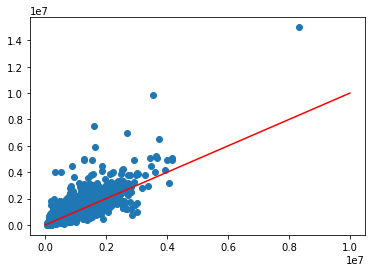

In [293]:
plt.scatter(np.exp(preds_test), y_test)
plt.plot([0,1e7], [0,1e7], color='red')
plt.show()